In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

No GPU was detected. CNNs can be very slow without a GPU.


In [6]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# 14.1 시각 피질 구조

* 시각 피질 안의 많은 뉴런이 작은 국부 수용장(Local Receptive Field)을 가진다는 것을 보였다.
* 이런 관찰을 포함한 여러 관찰들로부터 이웃한 고수준 뉴런이 이웃한 저수준 뉴런의 출력에 기반한다는 아이디어를 이끌어냈다.
* 시각 피질에 대한 이런 연구는 합성곱 신경망이라고 부르는 것으로 점진적으로 진화되었다.
* 우리에게 익숙한 완전 연결층과 시그모이드 활성화 함수 같은 구성 요소가 들어 있지만, 합성곱 층(Convolution Layer)과 풀링 층(Pooling Layer)이란 요소들도 존재한다.


* 이미지 인식 문제에 일반적인 완전 연결 층의 심층 신경망을 사용하지 않는 이유
 - 작은 이미지에서는 잘 작도아지만 큰 이미지에서는 아주 많은 파라미터가 만들어지기 때문에 문제가 발생한다.
  - CNN은 층을 부분적으로 연결하고 가중치를 공유하여 이 문제를 해결한다.

# 14.2 합성곱 층

* 첫 번째 합성곱 층의 뉴런은 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱 층 뉴런의 수용장 안에 있는 픽셀에만 연결된다.
* 두 번째 합성곱 층에 있는 각 뉴런은 첫 번째 층의 작은 사각 영역 안에 위치한 뉴런에 연결된다.
* 이런 구조는 네트워크가 첫 번째 은닉층에서는 작은 저수준 특성에 집중하고, 그 다음 은닉층에서는 더 큰 고수준 특성으로 조합해나가도록고 도와준다.

* 제로 패딩(Zero Padding)
 - 높이와 너비를 이전 층과 같이 하기 위해 입력의 주위에 0을 추가하는 것이 일반적이다. 
 
<img src="images/13_images/padding.png">

* 스트라이드(Stride)
 - 수용장 사이에 간격을 두어 큰 입력층을 훨씬 작은 층에 연결
 - 모델의 계산 복잡도를 낮춰준다.

## 14.2.1 필터

* 뉴런의 가중치는 수용장 크기의 작은 이미지로 표현할 수 있다.
* 필터(Filter)/합성곱 커널(Convolution Kernel)라 부르는 두 개의 가중치 세트

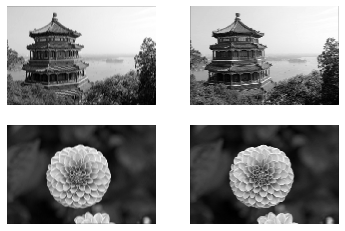

In [9]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [10]:
def crop(images):
    return images[150:220, 130:250]

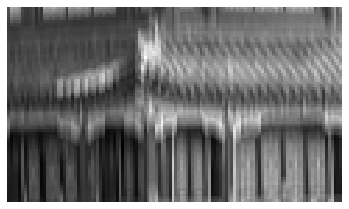

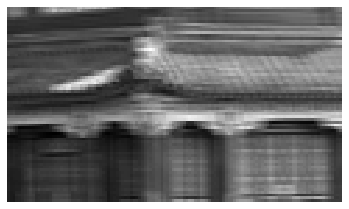

In [12]:
plot_image(crop(images[0, :, :, 0]))
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

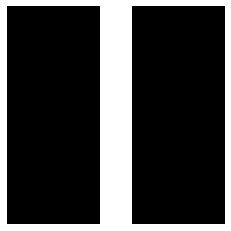

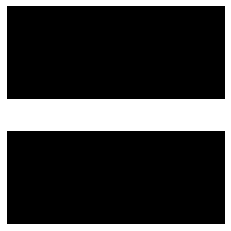

In [14]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

* 첫 번째 필터는 가운데 흰 수직선이 있는 검은 사각형
 - 이 가중치를 사용한 뉴런은 가운데 수직선 부분을 제외하고는 수용장에 있는 모든 것을 무시한다.
 * 두 번째 필터는 가운데 흰 수평선이 있는 검은 사각형
  - 이 가중치를 사용한 뉴런은 가운데 수평선 부분을 제외하고는 수용장 안의 모든것을 무시한다.


- 사각형 = 가운데 열은 1로 채워져있고 그 외에는 모두 0인 7X7행렬

* 층 전체 뉴런에 적용된 하나의 필터는 하나의 특성 맵(Feature Map)을 만든다.
 - 이 맵은 필터를 가장 크게 활성화시키는 이미지의 영역을 강조한다.

## 14.2.2 여러 가지 특성 맵 쌓기

* 위와 같은 예시는 단순함을 유지하기 위해 합성곱 층의 출력을 2D층으로 표현했지만, 실제 합성곱 층은 여러 가지 필터를 가지고 필터마다 하나의 특성 맵을 출력하므로 3D로 표현하는 것이 더 정확하다.
* 각 특성 맵의 픽셀은 하나의 뉴런에 해당하고, 하나의 특성 맵 안에서는 모든 뉴런이 같은 파라미터를 공유하지만, 다른 특성 맵에 있는 뉴런은 다른 파라미터를 사용한다.
 - 하나의 합성곱 층이 입력에 여러 필터를 동시에 적용하여 입력에 있는 여러 특성을 감지할 수 있다.
* 입력 이미지는 컬러 채널(Channel)마다 하나씩 여러 서브 층으로 구성되기도 한다.
 - 컬러 채널은 RGB
 - 흑색 이미지는 하나의 채널
 - 어떤 이미지는 더 많은 채널을 가질 수 있다. ex) 적외선이 기록된 위성 이미지


$$
z_{i, j, k}=b_{k}+\sum_{u=0}^{f_h-1}\sum_{v=0}^{f_w-1}\sum_{k'=0}^{f_{n'}-1}x_{i',j',k}
$$
$$
i' = i X S_h+u
$$
$$
j' = j X S_h+v
$$

* $z_{i, j, k}$는 합성곱 층의 k 특성맵에서 i행, j열에 위치한 뉴런의 출력
* $s_h, s_w$는 수직과 수평 스트라이드, $f_h, f_w$는 수용장의 높이와 너비, $f_{n'}$는 이전 층에 있는 특성 맵의 수
* $x_{i', j', k'}$는 l-1층의 행, 열, 특성 맵에 있는 뉴런의 출력
* $b_k$는 k 특성 맵의 편향. 이를 k 특성 맵의 전체 밝기를 조정하는 다이얼로 생각
* $w_{u, v, k', k}$는 l층의 k 특성 맵에 있는 모든 뉴런과 행, 열, 특성 맵에 위치한 입력 사이의 연결 가중치

## 14.2.3 텐서플로 구현

* 텐서플로에서 각 입력 이미지는 보통 [높이, 너비, 채널] 형태의 3D텐서로 표현된다.
* 하나의 미니배치는 [미니배치 크기, 높이, 너비, 채널] 형태의 4D텐서로 표현된다.
* 합성곱 층의 가중치는 [$f_h, f_w, f_{n'}, f_n]$ 형태의 4D 텐서로 표현된다.
* 합성곱 층의 편향은 간단하게 [$f_n$]형태의 1D 텐서로 나타낸다.


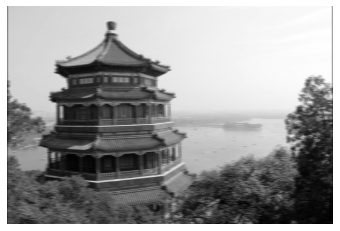

In [17]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

 - 각 컬러 채널의 픽셀 강도는 0 ~ 255 사이의 값을 가진 바이트 하나로 표현된다. 이 특성을 255로 나누어 0 ~ 1사이의 실수로 바꾼다.
 - 그 다음 두 개의 7X7 필터를 만든다.(하나는 가운데 흰 수직선, 다른 하나는 가운데 흰 수평선)
 - 텐서플로 저수준 딥러닝 API중 하나인 tf.nn.conv2d() 함수를 사용해 이 필터를 두 이미지에 적용한다. 제로 패딩(padding="SAM")과 스트라이드 1을 사용
 - 마지막으로 만들어진 특성 맵 중 하나를 그래프로 그린다.

* tf.nn.conv2d()
 - images는 입력의 미니배치(4D 텐서)
 - filters는 적용될 일련의 필터(4D 텐서)
 - strides는 1이나 4개의 원소를 갖는 1D 배열로 지정할 수 있다. 배치 스트라이드(일부 샘플을 건너 뛰기 위해)와 채널 스트라이드(이전 층의 특성 맵이나 채널을 건너뛰기 위해)를 지정하는데 사용될지도 모른다.
 - padding은 "VALID"와 "SAM" 중 하나를 지정한다.
   - "VALID", 합성곱 층에 제로 패딩을 사용하지 않는다. 즉, 모든 뉴런의 수용장이 입력 안쪽 영역에만 놓인다는 의미
   - "SAM", 필요한 경우 합성곱 층에 제로 패딩을 사용한다. 이 경우 출력 크기는 입력 뉴런 수를 스트라이드로 나누어올림한 것과 같다. stride=1이면 층의 출력이 입력과 동일한 공간 방향 차원을 가진다.


In [18]:
#앞선 예에서는 필터를 직접 지정했지만, 변수를 직접만드는 것보단 layer층을 사용
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

In [19]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [20]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [21]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [22]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## 14.2.4 메모리 요구 사항

* 추론을 할 때는 하나의 층이 점유하고 있는 RAM은 다음 층의 계산이 완료되자마자 해제될 수 있다.
* 그러므로 연속된 두 개의 층에서 필요로 하는 만큼의 RAM만 가지고 있으면 된다.
* 하지만 훈련하는 동안에 정방향에서 계산했던 모든 값이 역방향을 위해 보존되어야 한다.
* 그래서 각 층에서 필요한 RAM양의 전체 합만큼 필요하다.
 - 메모리 부족으로 훈련이 실패한다면 미니배치 크기를 줄여본다.
 - 스트라이드를 사용해 차원을 줄이거나 몇 개의 층을 제거한다.
 - 32비트 부동소수 대신 16비트 부동소스를 사용한다.
 - 여러 장치에 CNN을 분산시킨다.

# 14.3 풀링층

* 풀링 층의 목적은 계산량과 메모리 사용량, 과적합의 위험등을 줄이기 위해 입력 이미지의 부표본(Subsample)을 만드는 것이다.
* 합성곱 층에서와 마찬가지로 풀링 층의 각 뉴런은 이전 층의 작은 사각 영역의 수용장 안에 있는 뉴런의 출력과 연결되어 있다. 이전과 동일하게 크기, 스트라이드, 패딩 유형을 지정해야 한다.
* 풀링 뉴런은 가중치가 없다. 즉, 최대, 평균 같은 합산 함수를 사용해 입력값을 더하는 것
* 널리 사용되는 풀링 층인 최대 풀링 층(Max Pooling Layer)
 - 풀링 커널(Pooling Kernel)과 스트라이드를 사용하며 패딩은 없다.
 - 각 수용장에서 가장 큰 입력값이 다음 층으로 전달되고, 다른 값은 버려진다.
 - 최대 풀링은 작은 변화에도 일정 수준의 불변성을 만들어준다.
 - 단점으로는 매우 파괴적인 층이다. 2X2 커널과 스트라이드 2를 사용하더라도 입력값의 75%를 잃게 된다.
<img src = "images/14_images/pooling.png">
<img src = "images/14_images/pooling02.png">

* 평균 풀링 층(Average Pooling Layer)
 - 최댓값이 아닌 평균을 계산하는 것만 빼고 최대 풀링 층과 동일하게 작동한다.
 - 최댓값을 계산하는 것보다 정보 손실이 적다.
 - 최대 풀링보다 연산 비용이 더 든다.

* 전역 평균 풀링 층(Global Average Pooling Layer)
 - 각 특성 맵의 평균을 계산
 - 각 샘플의 특성 맵마다 하나의 숫자를 출력
 - 매우 파괴적인 연산이지만 출력층에는 유용할 수 있다.
 

## 14.3.1 텐서플로 구현


* Maxpooling

In [23]:
#2X2커널을 이용한 최대 풀링 층
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [27]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

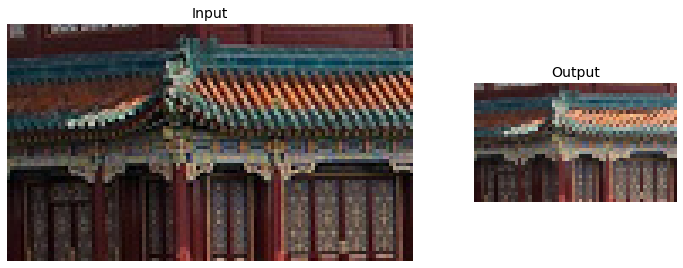

In [28]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

* 깊이방향 최대 풀링

In [29]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [30]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [31]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

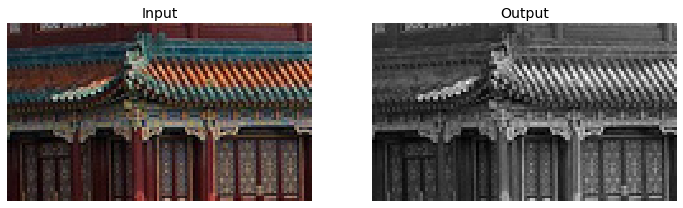

In [32]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

* 평균 풀링 층

In [33]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [34]:
output_avg = avg_pool(cropped_images)

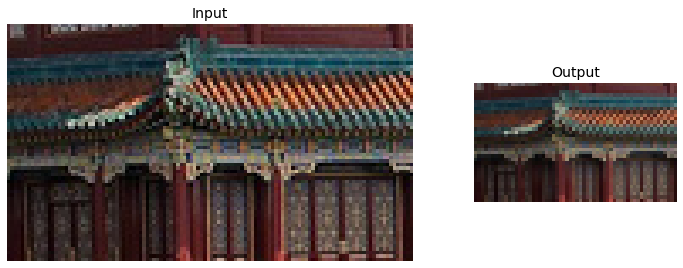

In [35]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

* 전역 평균 풀링 층

In [36]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [37]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# 14.4 CNN 구조

* 전형적인 CNN 구조는 합성곱 층을 몇 개 쌓고(각각 ReLU층을 그 뒤에 놓고), 그 다음에 풀링층을 쌓고, 그 다음에 또 합성곱 층을 몇개 더 쌓고, 그 다음에 다시 풀링 층을 쌓는 식이다.
* 네트워크를 통과하여 진행할 수록 이미지는 점점 작아지지만, 합성곱 층 때문에 일반적으로 점점 더 깊어진다.(더 많은 특성 맵을 가진다)
* 맨 위층에는 몇 개의 완전 연결 층(+ReLU)으로 구성된 일반적인 피드포워드 신경망이 추가되고, 마지막 층에서 예측을 출력한다.

In [39]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [40]:
# 패션 MNIST 데이터 셋 문제를 해결하기 위한 간단한 CNN
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [41]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 169s 98ms/step - loss: 0.7144 - accuracy: 0.7519 - val_loss: 0.3886 - val_accuracy: 0.8600
Epoch 2/10
1719/1719 [==============================] - 176s 103ms/step - loss: 0.4233 - accuracy: 0.8570 - val_loss: 0.3216 - val_accuracy: 0.8856
Epoch 3/10
1719/1719 [==============================] - 179s 104ms/step - loss: 0.3610 - accuracy: 0.8776 - val_loss: 0.3109 - val_accuracy: 0.8880
Epoch 4/10
1719/1719 [==============================] - 173s 101ms/step - loss: 0.3286 - accuracy: 0.8906 - val_loss: 0.2881 - val_accuracy: 0.8930
Epoch 5/10
1719/1719 [==============================] - 167s 97ms/step - loss: 0.3120 - accuracy: 0.8932 - val_loss: 0.2871 - val_accuracy: 0.8970
Epoch 6/10
1719/1719 [==============================] - 173s 101ms/step - loss: 0.2897 - accuracy: 0.9015 - val_loss: 0.3009 - val_accuracy: 0.8926
Epoch 7/10
1719/1719 [==============================] - 170s 99ms/step - loss: 0.2804 - accuracy: 0.9051 - val_los

* 이미지가 크지 않아서 첫 번째 층은 64개의 필터와 스트라이드 1을 사용, 이미지가 28X28픽셀 크기이고, 하나의 컬러 채널이므로 입력값의 크기는 [28, 28, 1]로 지정
* 그 다음 풀링 크기가 2인 최대 풀링 층을 추가하여 공간 방향 차원을 절반으로 줄인다.
* 이와 동일한 구조를 반복
* CNN이 출력층에 다다를수록 필터 개수가 늘어난다. 저수준 특성의 개수는 적지만 이를 연결하여 고수준 특성을 만들 수 있는 방법이 많기 때문에 이런 구조가 합리적이다.
 - 일반적으로 필터 개수를 두 배로 늘리는 것이 일반적인 방법이다.
* 그 다음이 두 개의 은닉층과 하나의 출력층으로 구성된 완전 연결 네트워크. 밀집 네트워크는 샘플의 특성으로 1D 배열을 기대하므로 입력을 일렬로 펼쳐야 한다. 또 밀집 층 사이에 과대적합을 줄이기 위해 50%d의 드롭아웃 비율을 가진 드롭아웃 층을 추가한다.

## 14.4.1 LeNet-5

* 1998년에 얀 르쿤이 만들었으며 손글시 숫자 인식에 널리 사용되었다.

<img src="images/14_images/LeNet-5.png">

In [47]:
from keras.models import Sequential
from keras import models, layers
import keras
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

* 출력층이 조금 특별하다. 입력과 가중치 벡터를 행렬 곱셈하는 대신 각 뉴런에서의 입력 벡터와 가중치 벡터 사이의 유클리드 거리를 출력한다. 각 출력은 이미지가 얼마나 특정 숫자 클래스에 속하는지 측정한다.

## 14.4.2 AlexNet

* LeNet-5보다 깊이가 깊으나, 구조가 비슷하며, 처음으로 합성곱 층 위에 풀링 층을 쌓지 않고 합성곱 끼리 쌓았다. 
<img src="images/14_images/AlexNet.png">

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(17))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 6, 6, 384)        

* 과대적합을 줄이기 위해 저자들이 사용한 두 가지 규제 기법
 - 훈련하는 동안 출력에 드롭아웃을 50%비율로 적용
 - 훈련 이미지를 랜덤하게 여러 간격으로 이동하거나 수평으로 뒤집고, 조명을 바꾸는 식으로 데이터 증식(Data Augmentation)을 수행
* 후반 층 단계에 LRN(Local Response Normalization)이라 부르는 경쟁적인 정규화 단계를 사용

## 14.4.3 GoogLeNet

* 인셉션 모듈이라는 서브 네트워크를 가지고 있어서 이전의 구조보다 훨씬 효과적으로 파라미터를 사용한다.

<img src="images/14_images/GoogLeNet_Inception.png">

In [51]:
def create_googlenet(weights_path=None):
    # creates GoogLeNet a.k.a. Inception v1 (Szegedy, 2015)
    input = Input(shape=(3, 224, 224))

    input_pad = ZeroPadding2D(padding=(3, 3))(input)
    conv1_7x7_s2 = Conv2D(64, (7,7), strides=(2,2), padding='valid', activation='relu', name='conv1/7x7_s2', kernel_regularizer=l2(0.0002))(input_pad)
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(conv1_7x7_s2)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    pool1_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool1/3x3_s2')(pool1_helper)
    pool1_norm1 = LRN(name='pool1/norm1')(pool1_3x3_s2)

    conv2_3x3_reduce = Conv2D(64, (1,1), padding='same', activation='relu', name='conv2/3x3_reduce', kernel_regularizer=l2(0.0002))(pool1_norm1)
    conv2_3x3 = Conv2D(192, (3,3), padding='same', activation='relu', name='conv2/3x3', kernel_regularizer=l2(0.0002))(conv2_3x3_reduce)
    conv2_norm2 = LRN(name='conv2/norm2')(conv2_3x3)
    conv2_zero_pad = ZeroPadding2D(padding=(1, 1))(conv2_norm2)
    pool2_helper = PoolHelper()(conv2_zero_pad)
    pool2_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool2/3x3_s2')(pool2_helper)

    inception_3a_1x1 = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3a/1x1', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_3a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3_reduce)
    inception_3a_3x3 = Conv2D(128, (3,3), padding='valid', activation='relu', name='inception_3a/3x3', kernel_regularizer=l2(0.0002))(inception_3a_3x3_pad)
    inception_3a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5_reduce)
    inception_3a_5x5 = Conv2D(32, (5,5), padding='valid', activation='relu', name='inception_3a/5x5', kernel_regularizer=l2(0.0002))(inception_3a_5x5_pad)
    inception_3a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3a/pool')(pool2_3x3_s2)
    inception_3a_pool_proj = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3a/pool_proj', kernel_regularizer=l2(0.0002))(inception_3a_pool)
    inception_3a_output = Concatenate(axis=1, name='inception_3a/output')([inception_3a_1x1,inception_3a_3x3,inception_3a_5x5,inception_3a_pool_proj])

    inception_3b_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/1x1', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3_reduce)
    inception_3b_3x3 = Conv2D(192, (3,3), padding='valid', activation='relu', name='inception_3b/3x3', kernel_regularizer=l2(0.0002))(inception_3b_3x3_pad)
    inception_3b_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5_reduce)
    inception_3b_5x5 = Conv2D(96, (5,5), padding='valid', activation='relu', name='inception_3b/5x5', kernel_regularizer=l2(0.0002))(inception_3b_5x5_pad)
    inception_3b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3b/pool')(inception_3a_output)
    inception_3b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3b/pool_proj', kernel_regularizer=l2(0.0002))(inception_3b_pool)
    inception_3b_output = Concatenate(axis=1, name='inception_3b/output')([inception_3b_1x1,inception_3b_3x3,inception_3b_5x5,inception_3b_pool_proj])

    inception_3b_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_output)
    pool3_helper = PoolHelper()(inception_3b_output_zero_pad)
    pool3_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool3/3x3_s2')(pool3_helper)

    inception_4a_1x1 = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_4a/1x1', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_4a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3_reduce)
    inception_4a_3x3 = Conv2D(208, (3,3), padding='valid', activation='relu', name='inception_4a/3x3' ,kernel_regularizer=l2(0.0002))(inception_4a_3x3_pad)
    inception_4a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5_reduce)
    inception_4a_5x5 = Conv2D(48, (5,5), padding='valid', activation='relu', name='inception_4a/5x5', kernel_regularizer=l2(0.0002))(inception_4a_5x5_pad)
    inception_4a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4a/pool')(pool3_3x3_s2)
    inception_4a_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4a/pool_proj', kernel_regularizer=l2(0.0002))(inception_4a_pool)
    inception_4a_output = Concatenate(axis=1, name='inception_4a/output')([inception_4a_1x1,inception_4a_3x3,inception_4a_5x5,inception_4a_pool_proj])

    loss1_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss1/ave_pool')(inception_4a_output)
    loss1_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss1/conv', kernel_regularizer=l2(0.0002))(loss1_ave_pool)
    loss1_flat = Flatten()(loss1_conv)
    loss1_fc = Dense(1024, activation='relu', name='loss1/fc', kernel_regularizer=l2(0.0002))(loss1_flat)
    loss1_drop_fc = Dropout(rate=0.7)(loss1_fc)
    loss1_classifier = Dense(1000, name='loss1/classifier', kernel_regularizer=l2(0.0002))(loss1_drop_fc)
    loss1_classifier_act = Activation('softmax')(loss1_classifier)

    inception_4b_1x1 = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4b/1x1', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_reduce = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4b_3x3_reduce)
    inception_4b_3x3 = Conv2D(224, (3,3), padding='valid', activation='relu', name='inception_4b/3x3', kernel_regularizer=l2(0.0002))(inception_4b_3x3_pad)
    inception_4b_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4b_5x5_reduce)
    inception_4b_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4b/5x5', kernel_regularizer=l2(0.0002))(inception_4b_5x5_pad)
    inception_4b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4b/pool')(inception_4a_output)
    inception_4b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4b/pool_proj', kernel_regularizer=l2(0.0002))(inception_4b_pool)
    inception_4b_output = Concatenate(axis=1, name='inception_4b/output')([inception_4b_1x1,inception_4b_3x3,inception_4b_5x5,inception_4b_pool_proj])

    inception_4c_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/1x1', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4c_3x3_reduce)
    inception_4c_3x3 = Conv2D(256, (3,3), padding='valid', activation='relu', name='inception_4c/3x3', kernel_regularizer=l2(0.0002))(inception_4c_3x3_pad)
    inception_4c_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4c/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4c_5x5_reduce)
    inception_4c_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4c/5x5', kernel_regularizer=l2(0.0002))(inception_4c_5x5_pad)
    inception_4c_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4c/pool')(inception_4b_output)
    inception_4c_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4c/pool_proj', kernel_regularizer=l2(0.0002))(inception_4c_pool)
    inception_4c_output = Concatenate(axis=1, name='inception_4c/output')([inception_4c_1x1,inception_4c_3x3,inception_4c_5x5,inception_4c_pool_proj])

    inception_4d_1x1 = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4d/1x1', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_reduce = Conv2D(144, (1,1), padding='same', activation='relu', name='inception_4d/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4d_3x3_reduce)
    inception_4d_3x3 = Conv2D(288, (3,3), padding='valid', activation='relu', name='inception_4d/3x3', kernel_regularizer=l2(0.0002))(inception_4d_3x3_pad)
    inception_4d_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4d/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4d_5x5_reduce)
    inception_4d_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4d/5x5', kernel_regularizer=l2(0.0002))(inception_4d_5x5_pad)
    inception_4d_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4d/pool')(inception_4c_output)
    inception_4d_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4d/pool_proj', kernel_regularizer=l2(0.0002))(inception_4d_pool)
    inception_4d_output = Concatenate(axis=1, name='inception_4d/output')([inception_4d_1x1,inception_4d_3x3,inception_4d_5x5,inception_4d_pool_proj])

    loss2_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss2/ave_pool')(inception_4d_output)
    loss2_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss2/conv', kernel_regularizer=l2(0.0002))(loss2_ave_pool)
    loss2_flat = Flatten()(loss2_conv)
    loss2_fc = Dense(1024, activation='relu', name='loss2/fc', kernel_regularizer=l2(0.0002))(loss2_flat)
    loss2_drop_fc = Dropout(rate=0.7)(loss2_fc)
    loss2_classifier = Dense(1000, name='loss2/classifier', kernel_regularizer=l2(0.0002))(loss2_drop_fc)
    loss2_classifier_act = Activation('softmax')(loss2_classifier)

    inception_4e_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_4e/1x1', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4e/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3_reduce)
    inception_4e_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_4e/3x3', kernel_regularizer=l2(0.0002))(inception_4e_3x3_pad)
    inception_4e_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4e/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5_reduce)
    inception_4e_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_4e/5x5', kernel_regularizer=l2(0.0002))(inception_4e_5x5_pad)
    inception_4e_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4e/pool')(inception_4d_output)
    inception_4e_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4e/pool_proj', kernel_regularizer=l2(0.0002))(inception_4e_pool)
    inception_4e_output = Concatenate(axis=1, name='inception_4e/output')([inception_4e_1x1,inception_4e_3x3,inception_4e_5x5,inception_4e_pool_proj])

    inception_4e_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_output)
    pool4_helper = PoolHelper()(inception_4e_output_zero_pad)
    pool4_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool4/3x3_s2')(pool4_helper)

    inception_5a_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_5a/1x1', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_5a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3_reduce)
    inception_5a_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_5a/3x3', kernel_regularizer=l2(0.0002))(inception_5a_3x3_pad)
    inception_5a_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_5a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5a_5x5_reduce)
    inception_5a_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5a/5x5', kernel_regularizer=l2(0.0002))(inception_5a_5x5_pad)
    inception_5a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5a/pool')(pool4_3x3_s2)
    inception_5a_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5a/pool_proj', kernel_regularizer=l2(0.0002))(inception_5a_pool)
    inception_5a_output = Concatenate(axis=1, name='inception_5a/output')([inception_5a_1x1,inception_5a_3x3,inception_5a_5x5,inception_5a_pool_proj])

    inception_5b_1x1 = Conv2D(384, (1,1), padding='same', activation='relu', name='inception_5b/1x1', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_reduce = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_5b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3_reduce)
    inception_5b_3x3 = Conv2D(384, (3,3), padding='valid', activation='relu', name='inception_5b/3x3', kernel_regularizer=l2(0.0002))(inception_5b_3x3_pad)
    inception_5b_5x5_reduce = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5b_5x5_reduce)
    inception_5b_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5b/5x5', kernel_regularizer=l2(0.0002))(inception_5b_5x5_pad)
    inception_5b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5b/pool')(inception_5a_output)
    inception_5b_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5b/pool_proj', kernel_regularizer=l2(0.0002))(inception_5b_pool)
    inception_5b_output = Concatenate(axis=1, name='inception_5b/output')([inception_5b_1x1,inception_5b_3x3,inception_5b_5x5,inception_5b_pool_proj])

    pool5_7x7_s1 = AveragePooling2D(pool_size=(7,7), strides=(1,1), name='pool5/7x7_s2')(inception_5b_output)
    loss3_flat = Flatten()(pool5_7x7_s1)
    pool5_drop_7x7_s1 = Dropout(rate=0.4)(loss3_flat)
    loss3_classifier = Dense(1000, name='loss3/classifier', kernel_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
    loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)

    googlenet = Model(inputs=input, outputs=[loss1_classifier_act,loss2_classifier_act,loss3_classifier_act])

## 14.4.4 VGGNet

* 2개 또는 3개의 합성곱 층 뒤에 풀링 층이 나오고 다시 2개 또는 3개의 합성곱 층과 풀링 층이 등장하는 식
* 마지막 밀집 네트워크는 2개의 은닉층과 출력층으로 이루어진다.
* 3X3필터만 사용한다.
<img src = "images/14_images/VGGNet.png">

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
input_shape = (224, 224, 3)

#Instantiate an empty model
model = Sequential([
Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Flatten(),
Dense(4096, activation='relu'),
Dense(4096, activation='relu'),
Dense(1000, activation='softmax')
])

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 56, 56, 256)      

## 14.4.5 ResNet

* 이런 깊은 네트워크를 훈련시킬 수 있는 핵심 요소는 스킵 연결(Skip Connection)이다.
 - 신경망을 훈련시킬 때는 목적 함수를 모델링하는 것이 목표이다.
 - 만약 입력 x을 네트워크의 출력에 더한다면 네트워크는 h(x)대신 f(x)=h(x)-x를 학습하게 된다. 이를 잔차 학습(Residual learning)이라고 한다.
 - 스킵 연결을 추가하면 네트워크는 입력과 같은 값을 출력한다. 즉 초기에는 항등 함수를 모델링 한다. 목적 함수가 항등 함수에 매우 가깝다면 훈련 속도가 매우 빨라진다.
 - 스킵 연결을 많이 추가하면 일부 층이 아직 학습되지 않았더라도 네트워크는 훈련을 시작할 수 있다.

<img src = "images/14_images/ResNet.png">

In [53]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform
input_shape = (64, 64, 3)
classes = 6

# Define the input as a tensor with shape input_shape
X_input = Input(input_shape)

# Zero-Padding
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',)(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Stage 2
X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

# Stage 3
X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

# Stage 4
X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

# Stage 5
X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

# AVGPOOL
X = AveragePooling2D((2,2), name='avg_pool')(X)

# output layer
X = Flatten()(X)
X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

# Create model
model = Model(inputs = X_input, outputs = X, name='ResNet50')

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'convolutional_block' is not defined

## 14.4.6 Xception

* 인셉션 모듈은 깊이별 분리 합성곱 층(Depthwise Separable Convolution Layer)이라는 특별한 층으로 대체했다.
 - 공간 패턴과 채널 사이 패턴을 분리하여 모델링 할 수 있다고 가장.
 - 이 층은 두개의 부분으로 구성
   - 첫 번째 부분은 하나의 공간 필터를 각 입력 특성 맵에 적용
   - 두 번째 부분은 채널 사이 패턴만 조사
 - 이런 이유로 Xception 구조는 2개의 일반 합성곱 층으로 시작한다. 이 구조의 나머지는 분리 합성곱만 사용
 
<img src ="images/14_images/Xception.png">

In [59]:
model=tf.keras.applications.xception.Xception(weights='imagenet',include_top=True)
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## 14.4.7 SENet

* 원래 구조에 모든 유닛에 SE블록이라는 작은 신경망을 추가하여 성능을 향상했다.
 - SE블록이 추가된 부분의 유닛의 출력을 깊이 차원에 초점을 맞추어 분석한다.
 - 어떤 특성이 일반적으로 동시에 가장 크게 활성화되는지를 학습한다.
 - 그 다음 이 정보를 사용하여 특성 맵을 보정한다.
 
<img src="images/14_images/SENet.png">

In [60]:
def Squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
    with tf.name_scope(layer_name) :
        squeeze = Global_Average_Pooling(input_x)

        excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name+'_fully_connected1')
        excitation = Relu(excitation)
        excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name+'_fully_connected2')
        excitation = Sigmoid(excitation)

        excitation = tf.reshape(excitation, [-1,1,1,out_dim])

        scale = input_x * excitation

        return scale

# 14.5 케라스를 사용해 ResNet-34 CNN구현하기

In [61]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [63]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_92 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_12 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 56, 56, 64)       

# 14.6 케라스에서 제공하는 사전훈련된 모델 사용하기

In [64]:
# 이미지넷 데이터셋에서 사전훈련된 ResNet-50 모델 로드
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 19s 0us/step


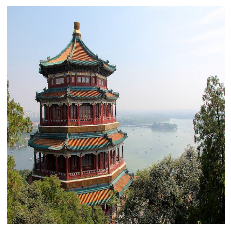

In [65]:
#이 모델은 224X224 크기의 이미지를 기대한다.
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

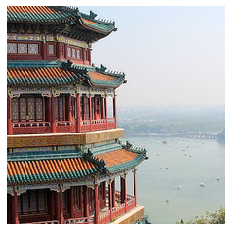

In [66]:

images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

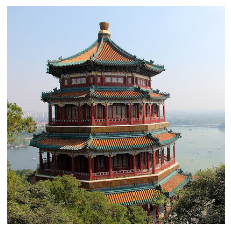

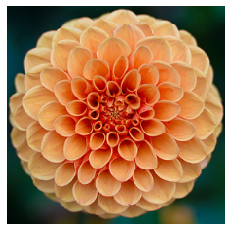

In [70]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [68]:
# 이미지 전처리
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)
Y_proba.shape

(2, 1000)

In [69]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 2us/step
Image #0
  n03877845 - palace       92.32%
  n03781244 - monastery    5.34%
  n02825657 - bell_cote    0.95%

Image #1
  n04522168 - vase         38.44%
  n07930864 - cup          8.86%
  n11939491 - daisy        8.09%



# 14.7 사전훈련된 모델을 사용한 전이 학습

* 충분하지 않은 훈련 데이터로 이미지 분류기를 훈련하려면 사전훈련된 모델의 하위층을 사용하는 것이 좋다.

In [80]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features['label'].num_classes

print(dataset_size, class_names, n_classes)

3670 ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'] 5


In [81]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

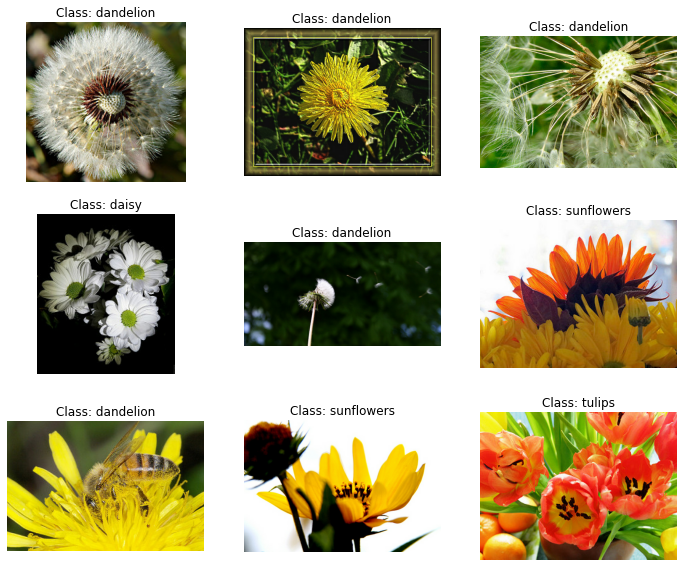

In [82]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [83]:
#이미지 전처리
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [84]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

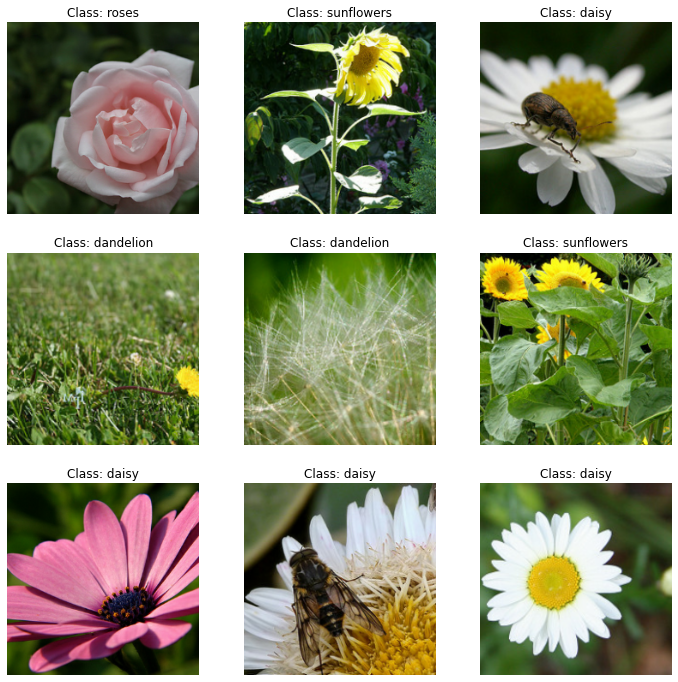

In [85]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [86]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [87]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_9
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_164
13 block2_pool
14 batch_normalization_132
15 add_72
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_165
23 block3_pool
24 batch_normalization_133
25 add_73
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_166
33 block4_pool
34 batch_normalization_134
35 add_74
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_75
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn


In [88]:
#훈련 초기에는 사전훈련된 층의 가중치를 동결
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 143s 2s/step - loss: 1.1561 - accuracy: 0.7994 - val_loss: 1.0798 - val_accuracy: 0.8382
Epoch 2/5
86/86 [==============================] - 141s 2s/step - loss: 0.5389 - accuracy: 0.8932 - val_loss: 0.7814 - val_accuracy: 0.8676
Epoch 3/5
86/86 [==============================] - 144s 2s/step - loss: 0.2721 - accuracy: 0.9339 - val_loss: 0.6914 - val_accuracy: 0.8787
Epoch 4/5
86/86 [==============================] - 144s 2s/step - loss: 0.2364 - accuracy: 0.9364 - val_loss: 0.5962 - val_accuracy: 0.8915
Epoch 5/5
86/86 [==============================] - 147s 2s/step - loss: 0.1861 - accuracy: 0.9488 - val_loss: 0.5978 - val_accuracy: 0.8787


In [89]:
#몇 번의 에포크 동안 훈련하면 75~80%, 이제 모든 층의 동결을 해제하고 훈련을 계속
# 사전훈련된 가중치가 훼손되는 것을 피하기 위해 훨씬 작은 학습률 사용
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 927s 11s/step - loss: 0.3351 - accuracy: 0.8903 - val_loss: 0.6046 - val_accuracy: 0.8676
Epoch 2/40
64/86 [=====================>........] - ETA: 3:49 - loss: 0.1351 - accuracy: 0.9609

KeyboardInterrupt: 

# 14.8 분류와 위치 추정

* 물체의 위치를 추정하는 것은 회귀 작업으로 나타낼 수 있다.
* 물체 주위의 바운딩 박스를 예측하는 일반적인 방법은 물체 중심의 수평, 수직 좌표와 높이, 너비를 예측하는 것이다.

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [ ]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

* MSE는 모델을 훈련하기 위한 손실 함수로 사용할 수 있다.
* 하지만 모델이 바운딩 박스를 얼마나 잘 예측하는지 평가하는 데 아주 좋은 지표는 아니다.
* 이때 널리 사용되는 지표는 IoU(Intersection over Union)
* 예측한 바운딩 박스와 타킷 바운딩 박스 사이에 중첩되는 영역을 전체 영역으로 나눈다.

# 14.9 객체 탐지

* 하나의 이미지에서 여러 물체를 분류하고 위치를 추정하는 작업을 객체 탐지(Object Detection)이라고 한다.
* 몇 년 전까지 사용되던 방법은 하나의 물체를 분류하고 위치를 찾는 분류기를 훈련한 다음 이미지를 모두 훑는 것이다.
 - 이 방식은 매우 쉽지만 조금씩 다른 위치에서 동일한 물체를 여러 번 감지하기 때문에 불필요한 바운딩 박스를 제거하기 위해 사후 처리가 필요하다.
* 그래서 사용하는 방법은 NMS(Non-Max Suppression)
 - CNN에 또 다른 꽃이 이미지에 존재하는지 확률을 추정하기 위해 존재여부 출력을 추가해야한다. 시그모이드 활성화 함수를 사용하고 이진 크로스 엔트로피 손실을 사용해 훈련할 수 있다. 그 다음 존재여부 점수가 어떤 임곗값 이하인 바운딩 박스를 모두 삭제한다.
 - 존재여부 점수가 가장 높은 바운딩 박스를 찾고, 이 박스와 많이 중첩된 다른 바운딩 박스를 모두 제거한다
 - 더는 제거할 바운딩 박스가 없을때까지 2단계를 반복한다.
 - 완전 합성곱 신경망(Fully Convolution Network, FCN)을 사용하면 CNN을 훨씬 빠르게 이미지에 슬라이딩 시킬 수 있다.

## 14.9.1 완전 합성곱 신경망

* 밀집층을 합성곱 층으로 바꾸려면 합성곱 층의 필터 개수와 밀집 층의 유닛 개수가 동일해야 하고 필터의 크기가 입력 특성 맵의 크기와 같아야한다. 그리고 "valid" 패딩도 사용해야 한다.
* 밀집 층은 입력 특성마다 하나의 가중치를 두므로 특정 입력 크기를 기대하지만, 합성곱 층은 어떤 크기의 이미도 처리할 수 있다.(대신 합성곱 층은 입력 채널마다 커널 가중치가 달라서 특정 개수의 채널을 기대한다.)
* FCN 방식은 이미지를 딱 한번만 처리하기 때문에 더 효율적이다. 이처럼 딱 한번만 본다는 Yolo(You only look once)는 유명한 객체 탐지 방법이다.

* mAP
 - 객체 탐지에서 널리 사용하는 평가 지표는 mAP(mean Average Percision)이다.
 - 최소 0% 재현율에서 얻을 수 있는 최대 정밀도를 ~100% 재현율에서의 최대 정밀도를 계산한다. 그다음 이 최대 정밀도를 평균한다. 이를 평균 정밀도(AP)라고 한다. 그리고 두 개 이상의 클래스가 있을 때는 각 클래스에 대해 AP를 계산한 다음 평균 AP를 계산한다. 이를 mAP라 한다.
 - 객체 탐지 시스템에서 위치를 잘못탐지하였다면 올바른 예측으로 포함시키지 않아야 한다.
 - 이를 위한 방법은 IOU 임계점을 정의하는 것이다.

In [90]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

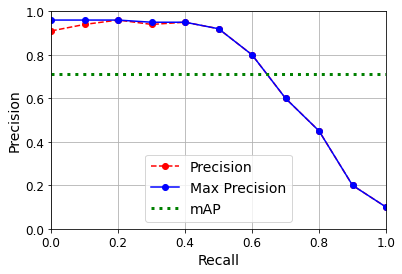

In [91]:

recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [92]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

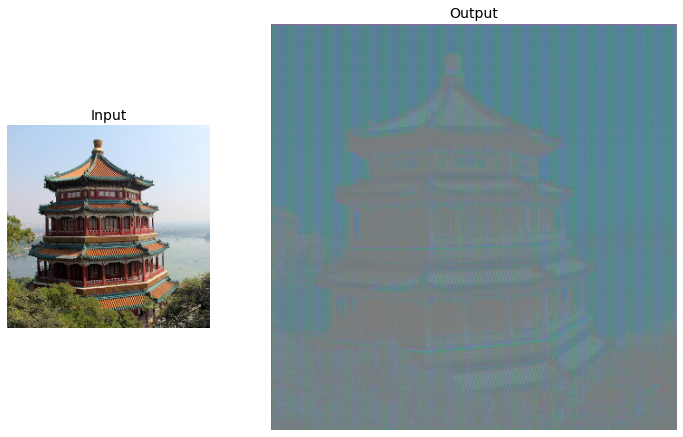

In [93]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [94]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [95]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

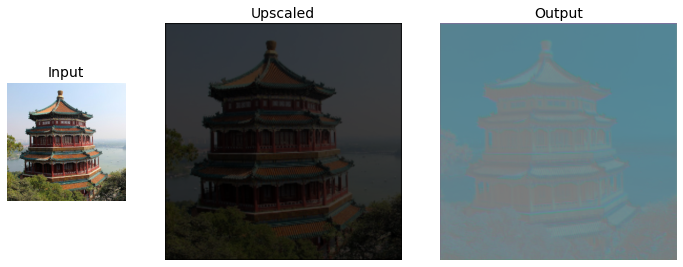

In [96]:

def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [97]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

## 14.10 시맨틱 분할

* 시맨틱 분할(Semantic Segmentation)에서 각 픽셀은 픽셀이 속한 개체의 클래스로 분류된다.
* 이 작업에서 어려운 점은 이미지가 일반적인 CNN을 통과할 때 점진적으로 위치 정보를 잃는 것이다.
* 저자들은 먼저 사전훈련된 CNN을 FCN으로 변환한다. 이 CNN이 입력 이미지에 적용하는  전체 스트라이드는 32이다. 이는 마지막 층이 입력 이미지보다 32배나 작은 특성 맵을 출력한다는 뜻이다. 이는 듬성듬성하기 때문에 해상도를 32배로 늘리는 업샘플링 층(Upsampling Layer)을 하나 추가한다.
* 그래도 정확도가 떨어지기 때문에 이를 개선하기 위해 아래쪽 층에서부터 스킵 연결을 추가했다.(이 방식은 풀링 층에서 잃은 일부 공간 정보를 복원한다.)
* 원본 이미지 크기보다 더 크게 업샘플링 하는 것도 가능하다. 이는 이미지 해상도를 증가시키는 데 사용할 수 있으며, 이를 초해상도(Super-Resolution)라고 부른다.